In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# Any results you write to the current directory are saved as output.

train = pd.read_csv('../input/X_train.csv')
y = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')
sub = pd.read_csv('../input/sample_submission.csv')

In [ ]:
import gc
import os
import logging
import datetime
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import xgboost as xgb

In [ ]:
#checking the Target distribution
plt.figure(figsize=(15,5))
sns.countplot(y=y['surface'],order=y.surface.value_counts().index)

# Take some sample and analyse

In [ ]:
## Take on of each surface

list_materials = y.surface.unique()

## Array of Dataframe, a dataframe for each material
sample = {}

## Take one serie for each material
for mat in list_materials:
    serie_id = y[y.surface==mat]['series_id'].values[0]
    print("material is %s serie taken %d"%(mat,serie_id))
    sample[mat]=train[train.series_id == serie_id]

In [ ]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

scatter = []
for s in sample:
    scatter.append(go.Scatter(x=np.arange(128), y=sample[s]['linear_acceleration_Z'], mode='lines',name=s))
iplot(scatter)

/opt/conda/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning:

Casting complex values to real discards the imaginary part



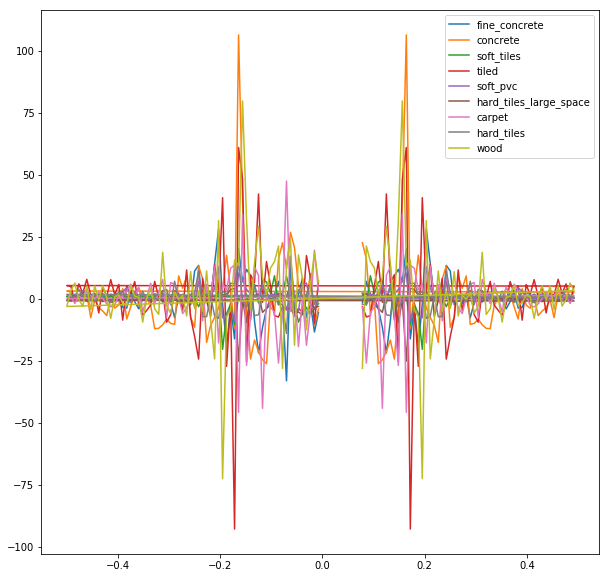

In [179]:
from scipy.signal import butter, lfilter, medfilt,lfilter_zi
from scipy.signal import freqs
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)

def low_pass_filter(data,order=1,alpha=0.05):
    b, a = butter(order,alpha)
    zi =  lfilter_zi(b, a)
    z,_ = lfilter(b, a,data,zi=zi*data.mean())
    return z

for s in sample:
    ## Take accZ
    y=sample[s]['linear_acceleration_Z']
    
    ## LowPass Filter it
    #low_pass_filter(y)
    
    sp = np.fft.fft(y)
    freq = np.fft.fftfreq(y.shape[-1])
    plt.plot(freq[10:],sp[10:],label=s)
    

plt.legend()
plt.show()

## Hypothesis : Measurement of vibration profile is better in a straight line

In [ ]:
scatter = []
for s in sample:
    scatter.append(go.Scatter(x=np.arange(128), y=sample[s].angular_velocity_Z, mode='lines',name=s))
iplot(scatter)

# Feature Engineering

In [ ]:
train.columns

In [ ]:


def serie_to_item(serie,serie_id):
    '''For 1 series_id (ie dataset), return a line with a '''
    '''value per feature '''
    ## Thoses are the columns from wich we will extract measurable
    cols = ['angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
        'linear_acceleration_Y', 'linear_acceleration_Z']
    
    '''Get a dataset an return a line of measurable'''
    
    feat = ["count","mean","std","min","25%","50%","75%","max"]
    
    new_items_names=[]
    new_data=[]
    for c in cols:
        #start_time = time.time()
        new_items_names.extend([c+'_'+i for i in feat])
        ## Extract measurable
        new_data.extend(serie[c].describe())
        #print("--- %s seconds ---" % (time.time() - start_time))
        
                
        ## Will contain name of new fields
    return pd.Series(new_data,index=new_items_names)

def prepare_data(data):
    '''Will transform each dataset series in 1-liner item in a new array'''
    '''For instance : [series_id,count,mean,std,min,...]'''
    '''Thus to extract measurable from each dataset and perform machine learning'''
    result = []
    list_series = data.series_id.unique()
    #for i in list_series[:10]:
    result = [serie_to_item(data[data.series_id==i],i) for i in list_series]
    return pd.DataFrame(result)



In [ ]:
prepared_data = prepare_data(train)

In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y['surface'])
y_encoded_df = pd.DataFrame(y_encoded,y.series_id)
train_X, test_X, train_y, test_y = train_test_split(prepared_data, y_encoded, test_size=0.30)

In [ ]:
from xgboost import XGBRegressor

my_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05,n_jobs=8)

# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(test_X, test_y)], verbose=False)

In [ ]:


preds = my_model.predict(test_X)
accuracy_score(test_y,preds)


In [ ]:
for i in [40]:
    my_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05,n_jobs=8)
    # Add silent=True to avoid printing out updates with each cycle
    my_model.fit(train_X, train_y, early_stopping_rounds=i, eval_set=[(test_X, test_y)], verbose=False)
    preds = my_model.predict(test_X)
    print("n_estimators :%d -- Acc : %f"%(i,accuracy_score(test_y,preds)))


In [ ]:
prepared_data_sub = prepare_data(test)

In [ ]:
prepared_data_sub.head()

In [ ]:
sub_preds = my_model.predict(prepared_data_sub)


result = pd.DataFrame()
result['series_id']=prepared_data_sub.index
result['surface']= encoder.inverse_transform(sub_preds)

result.to_csv('submission.csv', index=False)